# Analysis of the road safety data of the UK

In this project, we analyze the 2015 road safety data of the UK, which are about the circumstances of road accidents, the types of vehicles involved, and the consequential casualties. We try to use the data to answer some interesting questions regarding car accidents. The data sets are available [here](https://data.gov.uk/dataset/road-accidents-safety-data).

## Reading data

There are four files to be read, which contain the information of the accidents, vehicles, casualties, and variable encodings, respectively. We first read the files and then transform the missing or out of range values, which are represented as `-1` in the files, into `NaN`.

In [1]:
%matplotlib inline

import pandas as pd


df_acc = pd.read_csv('../Road/src/data_sets/Accidents_2015.csv',
                     dtype={'Accident_Index': str}, na_values=-1)
df_veh = pd.read_csv('../Road/src/data_sets/Vehicles_2015.csv', na_values=-1)
df_cas = pd.read_csv('../Road/src/data_sets/Casualties_2015.csv', na_values=-1)
df_enc = pd.read_excel('../Road/src/data_sets/Road-Accident-Safety-Data-Guide.xls', None)

## Cleaning data

We start with the accidents data. The date and time are transformed into `numpy.datetime64` objects first. Notice that there are 18 observations with time missing (not shown here) and they are "wrongly" parsed; however, this does not have a significant impact as they comprise a very small portion of the observations. There are also some variables with unknown values (different from the missing or out of range values); they are also transformed into `NaN`. In addition, there exist speed limits of 0 and 10, which were most probably wrongly recorded and are replaced with `NaN` as well.

Likewise, for the vehicles and casualties data, the unknown values are replaced with `NaN`. Also, the variables `Driver_IMD_Decile` and `Vehicle_IMD_Decile` in the vehicles data contain only `NaN`, so they are deleted from the vehicles data.

Finally, the three transformed data frames are merged on the `Accident_Index` and `Vehicle_Reference`.

In [2]:
import numpy as np


df_acc['Date_Time'] = pd.to_datetime(df_acc['Date'] + ' ' + df_acc['Time'], dayfirst=True)
df_acc['Year'] = df_acc['Date_Time'].dt.year
df_acc['Month'] = df_acc['Date_Time'].dt.month
df_acc['Day'] = df_acc['Date_Time'].dt.day
df_acc['Hour'] = df_acc['Date_Time'].dt.hour
df_acc['Minute'] = df_acc['Date_Time'].dt.minute
df_acc['Date'] = df_acc['Date_Time'].dt.date
df_acc['Time'] = df_acc['Date_Time'].dt.time
df_acc['Day_of_Week'] = df_acc['Date_Time'].dt.dayofweek

df_acc = df_acc.replace({'1st_Road_Class': {6: np.nan},
                         'Road_Type': {9: np.nan},
                         '2nd_Road_Class': {6: np.nan},
                         'Weather_Conditions': {9: np.nan},
                         'Urban_or_Rural_Area': {3: np.nan}})

df_acc.loc[df_acc['Speed_limit'] <= 10, 'Speed_limit'] = np.nan

df_veh = df_veh.replace({'Journey_Purpose_of_Driver': {6: np.nan},
                         'Sex_of_Driver': {3: np.nan}})

df_veh = df_veh.drop(['Driver_IMD_Decile', 'Vehicle_IMD_Decile'], 1)

df_cas = df_cas.replace({'Pedestrian_Location': {10: np.nan},
                         'Pedestrian_Movement': {9: np.nan},
                         'Pedestrian_Road_Maintenance_Worker': {3: np.nan}})

df = pd.merge(pd.merge(df_acc, df_veh, 'outer', 'Accident_Index'),
              df_cas, 'outer', ['Accident_Index', 'Vehicle_Reference'])

## Exploring data

The first thing we are interested in exploring is how the number of accidents varies with date and time. We plot five figures of the number of accidents against date, month and day, month, day of week, and hour.

In the figure by date (first figure), the curve fluctuates heavily as there is generally more traffic on weekdays than weekends. This can be verified by the figure by day of week (fourth figure). Also, a valley can be seen around Christmas, in accordance with the figure by month and day (second figure). In the figure by month (third figure), February has the fewest accidents, possibly due to the cold weather? In the figure by hour (fifth figure), two peaks can be observed around rush hours, during which traffic congestion is generally at its highest.

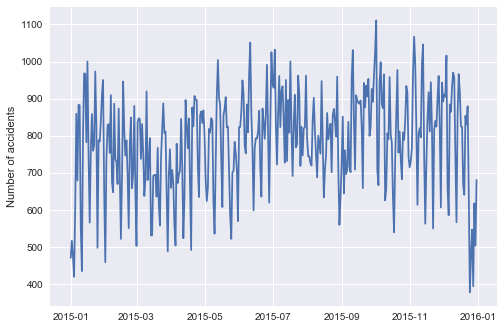

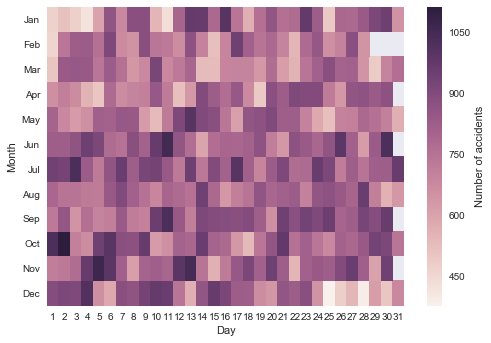

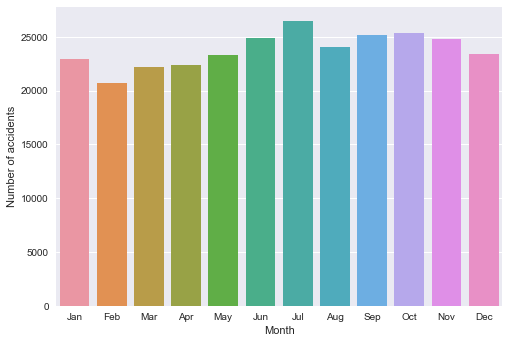

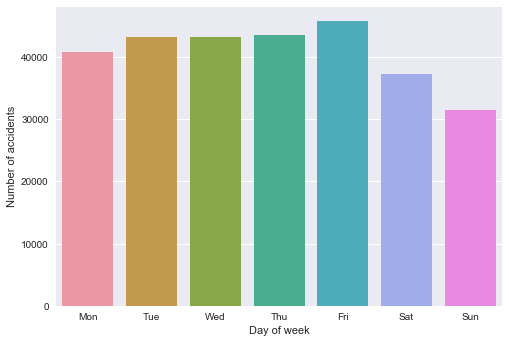

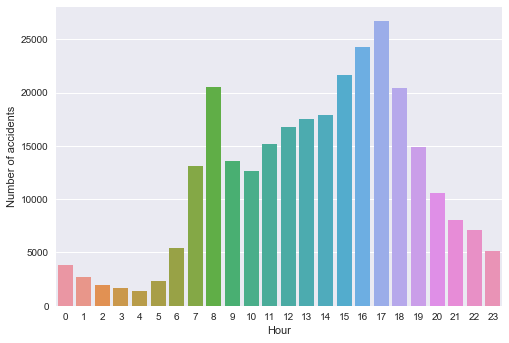

In [3]:
import calendar
import matplotlib.pyplot as plt
import seaborn as sns


df_date = df.groupby('Date').count()
fig_date, ax_date = plt.subplots()
ax_date.plot(df_date['Accident_Index'])
ax_date.set_ylabel('Number of accidents')

df_month_day = df.groupby(['Month', 'Day']).count().unstack()
fig_month_day, ax_month_day = plt.subplots()
sns.heatmap(df_month_day['Accident_Index'], ax=ax_month_day)
ax_month_day.set_xticklabels(np.arange(1, 32), rotation=0)
ax_month_day.set_yticklabels(calendar.month_abbr[13:0:-1], rotation=0)
ax_month_day.collections[0].colorbar.set_label('Number of accidents')


def plot_number(x, df, hue=None, x_label=None, x_tick_labels=None, legend_labels=None,
                legend_title=None):
    fig, ax = plt.subplots()
    sns.countplot(x, hue=hue, data=df, ax=ax)
    if x_label is not None:
        ax.set_xlabel(x_label)
    ax.set_ylabel('Number of accidents')
    if x_tick_labels is not None:
        ax.set_xticklabels(x_tick_labels)
    if hue is not None:
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, legend_labels, loc='upper left', bbox_to_anchor=(1, 1),
                  title=legend_title)


plot_number('Month', df, x_tick_labels=calendar.month_abbr[1:13])

plot_number('Day_of_Week', df, x_label='Day of week', x_tick_labels=calendar.day_abbr[0:7])

plot_number('Hour', df, x_tick_labels=np.arange(24))

plt.show()

As the number of accidents is related to the day of week and hour as suggested by the above figures, now, we would like to explore more on how they are related to other variables such as the accident severity.

Recall that from the figure by day of week, weekdays tend to have more accidents than weekends. However, weekends do not generally include public holidays, which are expected to see fewer accidents as well. Hence, we categorize days into business days and non-business days, rather than simply the day of week. In order to do this, a UK holiday calendar is defined. Notice that this is actually an England and Wales holiday calendar. However, this does not make a huge impact as the holidays of Scotland and Northern Ireland are similar and the holidays only constitute a small portion of a year.

In [4]:
import datetime
from pandas.tseries.holiday import AbstractHolidayCalendar
from pandas.tseries.holiday import DateOffset
from pandas.tseries.holiday import EasterMonday
from pandas.tseries.holiday import GoodFriday
from pandas.tseries.holiday import Holiday
from pandas.tseries.holiday import MO
from pandas.tseries.holiday import next_monday
from pandas.tseries.holiday import next_monday_or_tuesday


class EnglandAndWalesHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=next_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May bank holiday', month=5, day=1, offset=DateOffset(weekday=MO(1))),
        Holiday('Spring bank holiday', month=5, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Summer bank holiday', month=8, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Christmas Day', month=12, day=25, observance=next_monday),
        Holiday('Boxing Day', month=12, day=26, observance=next_monday_or_tuesday)
    ]


cal = EnglandAndWalesHolidayCalendar()
holidays = cal.holidays(datetime.date(2015, 1, 1), datetime.date(2015, 12, 31))

Based on the holiday calendar together with the day of week, we create a new variable called `Business_Day`, which is a binary qualitative variable that indicates whether the day is a business day or not. In addition, we add another variable `Time_Float`, which is the floating-point version of time.

In [5]:
df['Business_Day'] = 1
df.loc[df['Day_of_Week'].isin([5, 6]) | df['Date'].isin(holidays.date), 'Business_Day'] = 0

df['Time_Float'] = df['Hour'] + df['Minute'] / 60

Now, we try to see how time and business/non-business days are related to the accident severity. From the violin plot below, we can see more accidents around rush hours as the accident severity decreases on business days (green); namely, fatal accidents tend to be more spread out during a business day. For non-business days (blue), the number of accidents is more smoothly distributed during a day; in addition, an obvious increase in the number of fatal accidents can be seen between late nights and early mornings.

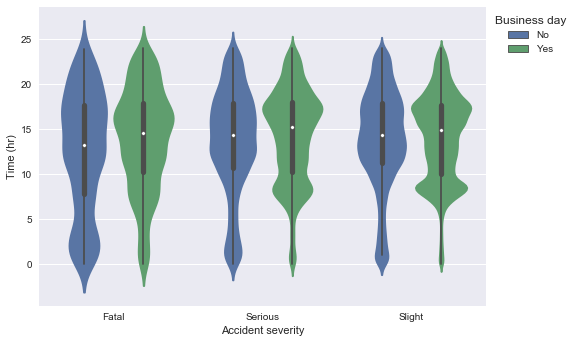

In [6]:
def plot_density(y, df, hue=None, y_label=None, legend_labels=None, legend_title=None):
    fig, ax = plt.subplots()
    sns.violinplot('Accident_Severity', y, hue, df, ax=ax)
    ax.set_xlabel('Accident severity')
    if y_label is not None:
        ax.set_ylabel(y_label)
    if legend_labels is not None:
        h, l = ax.get_legend_handles_labels()
        ax.legend(h, legend_labels, loc='upper left', bbox_to_anchor=(1, 1),
                  title=legend_title)
    ax.set_xticklabels(df_enc['Accident Severity']['label'])


plot_density('Time_Float', df, 'Business_Day', 'Time (hr)', ['No', 'Yes'], 'Business day')

plt.show()

In addition to time, we are also interested in other variables that might be related to the accident severity. Four variables, which are the speed limit, light condition, weather condition, and road surface condition, are selected from the accidents data, and the percentages of different accident severities in different categories of these variables are computed. Notice that there are no fatal accidents when the weather condition is snowing and high winds. Thus, the associated `NaN` percentage is assigned to zero.

In [7]:
import itertools


df_speed = df.groupby('Speed_limit')['Accident_Severity'].value_counts(True) \
    .reset_index(name='Percentage')

df_light = df.groupby('Light_Conditions')['Accident_Severity'].value_counts(True) \
    .reset_index(name='Percentage')

df_weather = df.groupby('Weather_Conditions')['Accident_Severity'].value_counts(True) \
    .reset_index(name='Percentage')
tmp = pd.DataFrame([x for x in itertools.product(df_weather['Weather_Conditions'].unique(),
                                                 df_weather['Accident_Severity'].unique())],
                   columns=['Weather_Conditions', 'Accident_Severity'])
df_weather = pd.merge(df_weather, tmp, 'outer',
                      ['Weather_Conditions', 'Accident_Severity']).fillna(0)

df_road = df.groupby('Road_Surface_Conditions')['Accident_Severity'].value_counts(True) \
    .reset_index(name='Percentage')

The stacked bar charts of these four variables are plotted. High speed and harsh external conditions generally lead to severe accidents (blue and green). Regarding the external conditions, visibility is the most significant factor, as suggested in the light condition figure (second figure) and the fog or mist category in the weather condition figure (third figure).

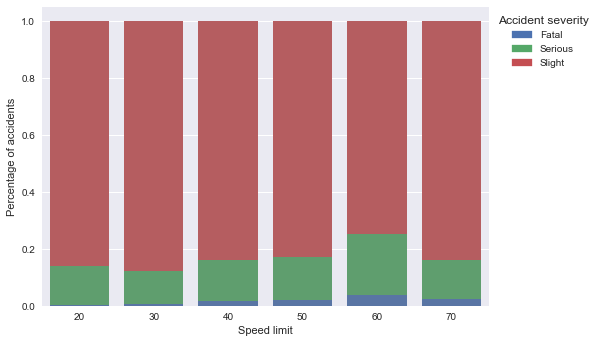

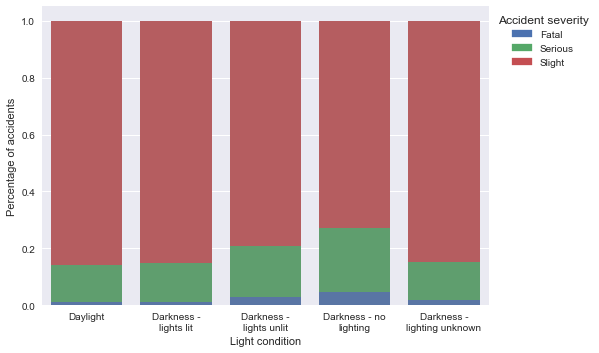

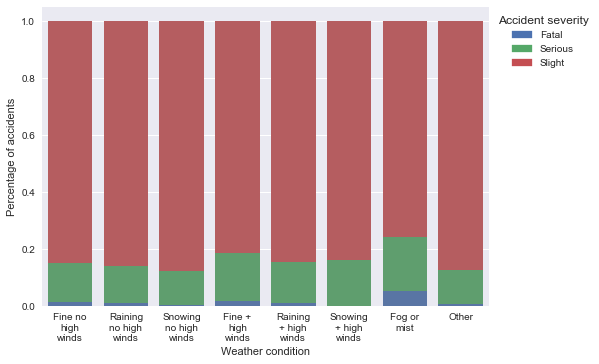

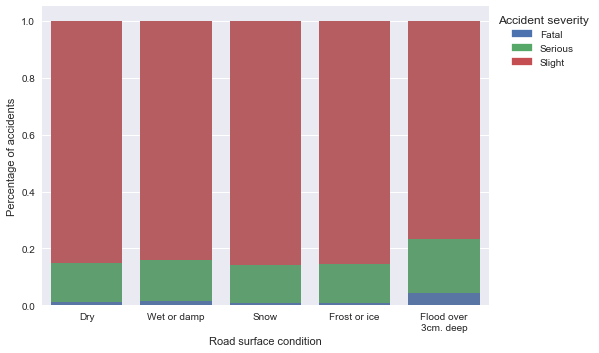

In [8]:
import matplotlib.patches as mpatches


def plot_percentage(x, df, x_label=None, x_tick_labels=None):
    fig, ax = plt.subplots()
    h = [None] * 3
    for i in np.arange(3):
        top = df[df['Accident_Severity'].isin(np.arange(1, i + 2))] \
            .groupby(x)['Percentage'].sum()
        diff = df[df['Accident_Severity'].isin([i + 1])].groupby(x)['Percentage'].sum()
        bottom = top - diff
        sns.barplot(x, 'Percentage', data=df[df['Accident_Severity'] == i + 1], ci=None,
                    color=sns.color_palette()[i], ax=ax, bottom=bottom)
        h[i] = mpatches.Patch(color=sns.color_palette()[i])
    if x_label is not None:
        ax.set_xlabel(x_label)
    ax.set_ylabel('Percentage of accidents')
    ax.legend(h, df_enc['Accident Severity']['label'], loc='upper left',
              bbox_to_anchor=(1, 1), title='Accident severity')
    if x_tick_labels is not None:
        ax.set_xticklabels(x_tick_labels)


plot_percentage('Speed_limit', df_speed, 'Speed limit', np.arange(20, 80, 10))

plot_percentage('Light_Conditions', df_light, 'Light condition',
                df_enc['Light Conditions']['label'][:-1].str.wrap(16))

plot_percentage('Weather_Conditions', df_weather, 'Weather condition',
                df_enc['Weather']['label'][:-2].str.wrap(8))

plot_percentage('Road_Surface_Conditions', df_road, 'Road surface condition',
                df_enc['Road Surface']['label'][:-1].str.wrap(12))

plt.show()

In addition to the accidents data, we now investigate more about the vehicles data. The percentages of the accident severity are plotted against the journey purpose (first figure) and the sex of the driver (second figure). Fatal (blue) and serious (green) accidents are much rarer (in percentage) when the purpose is concerning children. Also, male drivers tend to have more fatal and serious accidents (in percentage) compared to female drivers.

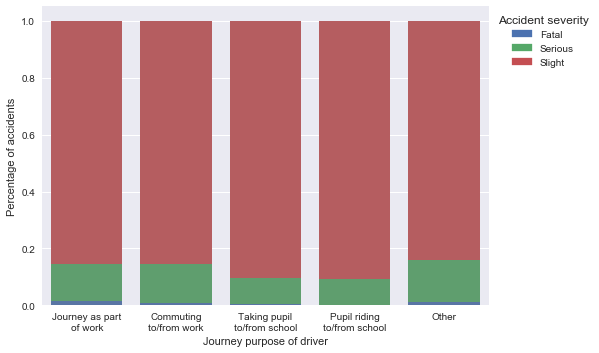

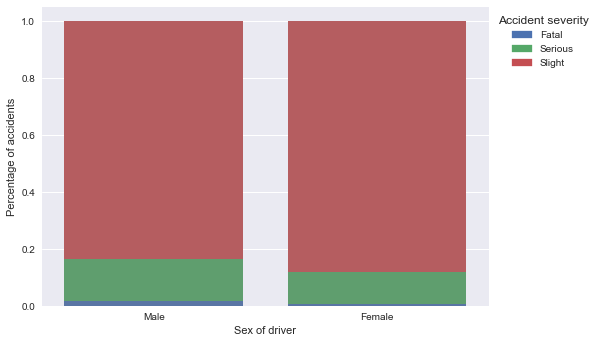

In [9]:
df_purpose = df.groupby('Journey_Purpose_of_Driver')['Accident_Severity'].value_counts(True) \
    .reset_index(name='Percentage')

df_sex_of_driver = df.groupby('Sex_of_Driver')['Accident_Severity'].value_counts(True) \
    .reset_index(name='Percentage')

plot_percentage('Journey_Purpose_of_Driver', df_purpose, 'Journey purpose of driver',
                df_enc['Journey Purpose']['label'][:-3].str.wrap(16))

plot_percentage('Sex_of_Driver', df_sex_of_driver, 'Sex of driver',
                df_enc['Sex of Driver']['label'][:-2])

plt.show()

The ages of the driver and vehicle are also analyzed, as shown in the scatter plot below. The age of the driver has little impact on the accident severity. By contrast, interestingly, older vehicles tend to have less serious accidents (blue and green), possibly because older vehicles are generally driven at a slower speed and/or with more caution?

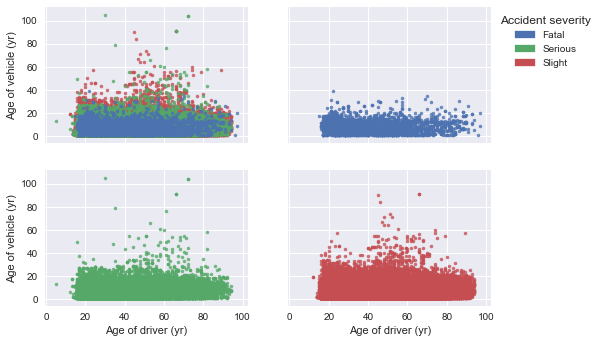

In [10]:
import matplotlib as mpl


fig_age, axes_age = plt.subplots(2, 2, 'all', 'all')
h_age = [None] * 3
for i in np.arange(3):
    p, q = divmod(i + 1, 2)
    sns.regplot('Age_of_Driver', 'Age_of_Vehicle', df[df['Accident_Severity'] == 3 - i],
                fit_reg=False, ci=None, color=sns.color_palette()[2 - i],
                scatter_kws={'s': mpl.rcParams['lines.markersize'] ** 2 / 4},
                ax=axes_age[0][0])
    sns.regplot('Age_of_Driver', 'Age_of_Vehicle', df[df['Accident_Severity'] == i + 1],
                fit_reg=False, ci=None, color=sns.color_palette()[i],
                scatter_kws={'s': mpl.rcParams['lines.markersize'] ** 2 / 4},
                ax=axes_age[p][q])
    h_age[i] = mpatches.Patch(color=sns.color_palette()[i])
for i in np.arange(4):
    p, q = divmod(i, 2)
    x_label = 'Age of driver (yr)' if p == 1 else ''
    y_label = 'Age of vehicle (yr)' if q == 0 else ''
    axes_age[p][q].set_xlabel(x_label)
    axes_age[p][q].set_ylabel(y_label)
axes_age[0][1].legend(h_age, df_enc['Accident Severity']['label'], loc='upper left',
                      bbox_to_anchor=(1, 1), title='Accident severity')

plt.show()

One last thing we would like to know from the vehicles data is whether the engine capacity is related to the accident severity. A boost in fatal accidents (blue) can be seen for vehicles of large engine capacity (above 10000); these vehicles are generally buses of high capacity or goods vehicles. On top, Vehicles of small engine capacity (below 1000) are more likely to be involved in slight accidents (red); these vehicles are generally motorcycles.

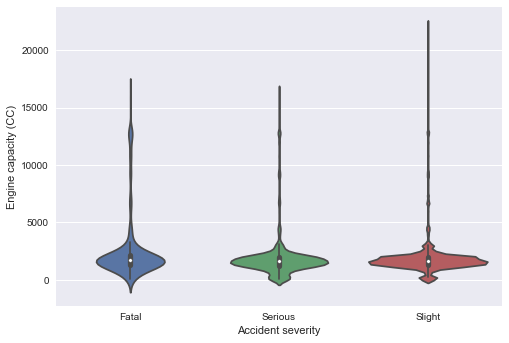

In [11]:
plot_density('Engine_Capacity_(CC)', df, y_label='Engine capacity (CC)')

plt.show()

Additionally, some interesting facts can also be observed in the casualties data. The percentages of different accident severities against the sex of casualty (first figure) are similar to those of the sex of driver. In the violin plot (second figure), young people are more likely to be the casualties of car accidents; however, female casualties (green) involved in fatal accidents are more smoothly distributed across age. In addition, drivers or riders constitute the biggest portion of casualties in car accidents and males (blue) account for two thirds of them (third figure).

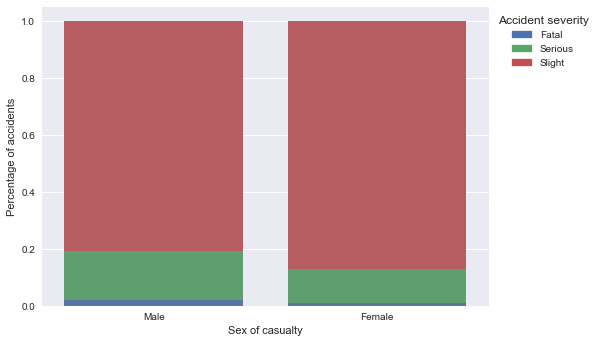

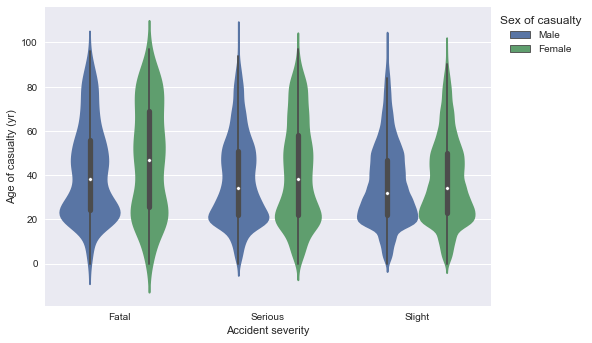

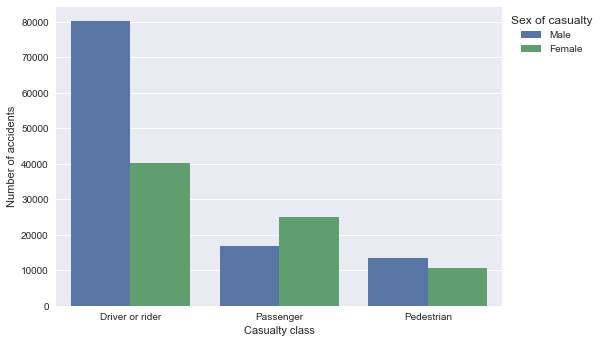

In [12]:
df_sex_of_casualty = df.groupby('Sex_of_Casualty')['Accident_Severity'].value_counts(True) \
    .reset_index(name='Percentage')

plot_percentage('Sex_of_Casualty', df_sex_of_casualty, 'Sex of casualty',
                df_enc['Sex of Casualty']['label'][:-1])

plot_density('Age_of_Casualty', df, 'Sex_of_Casualty', 'Age of casualty (yr)',
             df_enc['Sex of Casualty']['label'][:-1], 'Sex of casualty')

plot_number('Casualty_Class', df, 'Sex_of_Casualty', 'Casualty class',
            df_enc['Casualty Class']['label'], df_enc['Sex of Casualty']['label'][:-1],
            'Sex of casualty')

plt.show()

The last thing we are interested in this project is whether we can possibly use other variables in the data to discriminate the sex of driver. We first remove the variables that are redundant or of low interest, and then group the rest of the variables into quantitative and qualitative variables.

In [13]:
vars_to_remove = ['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
                  'Longitude', 'Latitude', 'Police_Force', 'Date', 'Day_of_Week', 'Time',
                  'Local_Authority_(District)', 'Local_Authority_(Highway)',
                  '1st_Road_Number', '2nd_Road_Number', 'LSOA_of_Accident_Location',
                  'Date_Time', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Vehicle_Reference',
                  'Age_Band_of_Driver', 'Casualty_Reference', 'Age_Band_of_Casualty']

qn_vars = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit', 'Age_of_Driver',
           'Engine_Capacity_(CC)', 'Age_of_Vehicle', 'Age_of_Casualty', 'Time_Float']

ql_vars = ['Accident_Severity', '1st_Road_Class', 'Road_Type', 'Junction_Detail',
           'Junction_Control', '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control',
           'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
           'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site',
           'Carriageway_Hazards', 'Urban_or_Rural_Area',
           'Did_Police_Officer_Attend_Scene_of_Accident', 'Vehicle_Type',
           'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location-Restricted_Lane',
           'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
           'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact',
           'Was_Vehicle_Left_Hand_Drive?', 'Journey_Purpose_of_Driver',
           'Propulsion_Code', 'Driver_Home_Area_Type', 'Casualty_Class', 'Sex_of_Casualty',
           'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger',
           'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
           'Casualty_Home_Area_Type', 'Casualty_IMD_Decile', 'Business_Day']

ql_code = ['Accident Severity', '1st Road Class', 'Road Type', 'Junction Detail',
           'Junction Control', '2nd Road Class', 'Ped Cross - Human', 'Ped Cross - Physical',
           'Light Conditions', 'Weather', 'Road Surface', 'Special Conditions at Site',
           'Carriageway Hazards', 'Urban Rural', 'Police Officer Attend', 'Vehicle Type',
           'Towing and Articulation', 'Vehicle Manoeuvre', 'Vehicle Location',
           'Junction Location', 'Skidding and Overturning', 'Hit Object in Carriageway',
           'Veh Leaving Carriageway', 'Hit Object Off Carriageway', '1st Point of Impact',
           'Was Vehicle Left Hand Drive', 'Journey Purpose', 'Sex of Driver',
           'Vehicle Propulsion Code', 'Home Area Type', 'Casualty Class', 'Sex of Casualty',
           'Casualty Severity', 'Ped Location', 'Ped Movement', 'Car Passenger',
           'Bus Passenger', 'Ped Road Maintenance Worker', 'Casualty Type', 'Home Area Type',
           'IMD Decile', 'Business Day']

resp = 'Sex_of_Driver'

df_x_qn = df[qn_vars]
df_x_ql = df[ql_vars]
df_y = df[resp]

We perform principal component analysis (PCA) on the variables to try to find a (dimension-reduced) set of features that might be helpful in separating the sex of driver. Notice that PCA is not a classifier; however, it can be utilized to give an indication whether such a set can be found. We first apply PCA onto quantitative variables. Based on the biplots below, none of the principal components have significant discriminatory power.

1.0


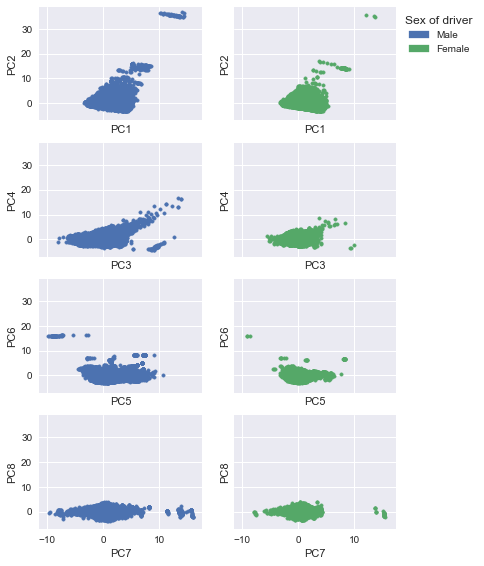

In [14]:
from sklearn import preprocessing
from sklearn.decomposition import PCA


def plot_pc(x, y):
    n = x.shape[1]
    odd = n % 2 != 0
    if odd:
        n += 1
        x = np.concatenate((x, np.zeros((x.shape[0], 1))), 1)
    n_rows = n // 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, 'all', 'all', figsize=(6.4, 4.8 * n_rows / 2))
    for i in np.arange(n):
        p, q = divmod(i, 2)
        axes[p][q].scatter(x[y == q + 1, p * 2], x[y == q + 1, p * 2 + 1],
                           s=mpl.rcParams['lines.markersize'] ** 2 / 4,
                           c=sns.color_palette()[q])
        axes[p][q].set_xlabel('PC' + str(p * 2 + 1))
        if not (odd and p == n_rows - 1):
            axes[p][q].set_ylabel('PC' + str((p + 1) * 2))
    h = [None] * 2
    for i in np.arange(2):
        h[i] = mpatches.Patch(color=sns.color_palette()[i])
    axes[0][1].legend(h, ['Male', 'Female'], loc='upper left', bbox_to_anchor=(1, 1),
                      title='Sex of driver')


x_qn = df_x_qn.fillna(df_x_qn.median())
x_qn = preprocessing.scale(x_qn)
pca_qn = PCA(8)
x_qn_rd = pca_qn.fit_transform(x_qn)
print(pca_qn.explained_variance_ratio_.sum())
plot_pc(x_qn_rd, df_y)

We now apply PCA onto (the weighted indicator matrix of) the qualitative variables, which is equivalent to multiple correspondence analysis. Notice that PCA can be performed onto a mix of quantitative and qualitative variables using techniques like [generalized singular value decomposition](https://arxiv.org/abs/1411.4911); however, we keep it simple in this project by treating quantitative and qualitative variables as two different sets. First, we transform the code of unknown values to `999` in the variable encodings data.

In [15]:
df_enc['Business Day'] = pd.DataFrame({'code': [0, 1], 'label': ['No', 'Yes']})
df_enc['Vehicle Propulsion Code'].loc[12, 'code'] = 999
df_enc['Vehicle Propulsion Code'] = df_enc['Vehicle Propulsion Code'] \
    .astype({'code': np.int64})
for var in ql_code:
    df_enc[var] = df_enc[var].replace({'code': {-1: 999}})
ql_vars_na = {'1st Road Class': 6,
              'Road Type': 9,
              '2nd Road Class': 6,
              'Weather': 9,
              'Urban Rural': 3,
              'Journey Purpose': 3,
              'Sex of Driver': 3,
              'Ped Location': 10,
              'Ped Movement': 9,
              'Ped Road Maintenance Worker': 9}
for key, value in ql_vars_na.items():
    df_enc[key] = df_enc[key].replace({'code': {value: 999}})

Then, we encode the qualitative variables using dummy variables and apply PCA onto the weighted version. Similarly, using the first 10 principal components, which explain 80% of the variance, it is difficult to discriminate the two classes.

0.808108203765


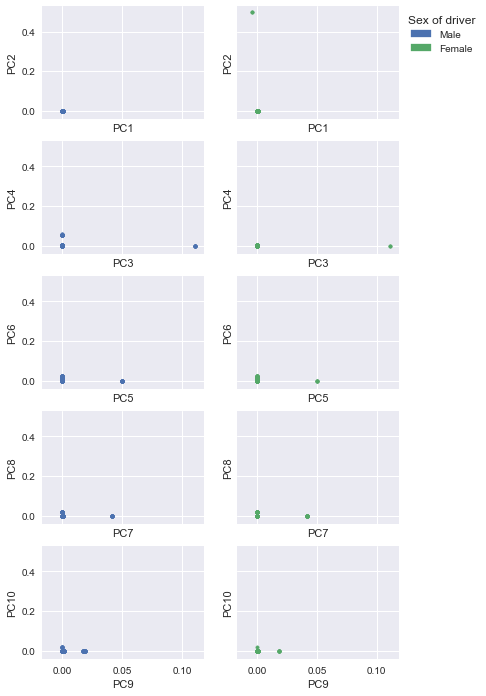

In [16]:
from sklearn.preprocessing import OneHotEncoder


def encode(df_transform, df_fit, ql_vars):
    enc = OneHotEncoder()
    dfs = []
    df_unknown = pd.DataFrame({'code': [999], 'label': ['Unknown']})
    for transform, fit in ql_vars.items():
        to_fit = [[x] for x in df_fit[fit].append(df_unknown)['code'].unique()]
        to_transform = [[x] for x in df_transform[transform]]
        enc.fit(to_fit)
        tmp = enc.transform(to_transform).toarray()
        columns = [transform + '.' + x for x in
                   df_fit[fit][df_fit[fit]['code'].isin(enc.active_features_[:-1])]
                   ['label']] + [transform + '.' + 'Unknown']
        tmp = pd.DataFrame(tmp, columns=columns)
        tmp = tmp / tmp.sum(0) - 1
        dfs.append(tmp)
    return dfs


encoded = encode(df_x_ql.fillna(999), df_enc, dict(zip(ql_vars, ql_code)))
x_ql = pd.DataFrame(pd.concat(encoded, 1)).fillna(0)
pca_ql = PCA(10)
x_ql_rd = pca_ql.fit_transform(x_ql)
print(pca_ql.explained_variance_ratio_.sum())
plot_pc(x_ql_rd, df_y)

Although PCA is not a classifier, the above analysis suggests that it is difficult to indicate whether the driver is male or female using (at least) the first few principal components. Other analysis like linear discriminant analysis, which is a classifier that takes the response into account, can also be performed to verify this point of view.